In [145]:
import os
import glob
import gzip
import pickle
from metient.util.globals import *
from metient.util import vertex_labeling_util as vutil
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
OUTPUT_DIR = os.path.join(REPO_DIR, 'jupyter_notebooks', 'output_plots')
DATASET_NAMES = ["Breast Cancer", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_bs16384_r1_03292024/calibrate",)]


In [176]:
def get_path_matrix(T, U):
    num_internal_clones = U.shape[1]-1
    T = T[:num_internal_clones,:num_internal_clones]
    P = vutil.get_path_matrix(T, remove_self_loops=True)
    B = vutil.get_mutation_matrix_tensor(T)
    # add a row of zeros to account for the non-cancerous root node
    B = torch.vstack([torch.zeros(B.shape[1]), B])
    # add a column of ones to indicate that every clone is a descendent of the non-cancerous root node
    B = torch.hstack([torch.ones(B.shape[0]).reshape(-1,1), B])
    F_hat = (torch.tensor(U)@B)
    #print(F_hat)
    return P

root_node_Us = []
all_Us = []
diff_of_node_and_descendants = []
prop_of_node_and_descendants = []

for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pid = fn.split("/")[-1].split("_")[0]
            print(pid)
            pkl = pickle.load(f)
            T = torch.tensor(pkl[OUT_ADJ_KEY][0])
            U = pkl[OUT_SUB_PRES_KEY]
            
            P = get_path_matrix(T,U)
            U = U[:,1:] # don't include column for normal cells
            root_node_Us.extend(U[:,0])
            
            for node_idx in range(U.shape[1]):
                descendants = np.where(P[node_idx] == 1)[0]
                if len(descendants) > 1:
                    print(node_idx, descendants)
                    for site_idx in range(U.shape[0]):
                        node_U = U[site_idx,node_idx]
                        
                        descendants_U = sum(U[site_idx,descendants])
                        diff_of_node_and_descendants.append(node_U-descendants_U)
                        if node_U > 0.05:
                            prop_of_node_and_descendants.append(node_U/(node_U+descendants_U))
                        #print(node_U, node_U/(node_U+descendants_U))
            for x in range(U.shape[0]):
                for y in range(U.shape[1]):
                    if U[x,y] > 0.05:
                        all_Us.append(U[x,y])
            

Breast Cancer 2
A1
0 [1 2 3 4 5 6 7 8 9]
2 [4 8 9]
3 [1 2 4 5 6 7 8 9]
6 [1 5 7]
A7
0 [1 2 3 4 5 6 7 8 9]
2 [1 6]
4 [1 2 3 6]
5 [8 9]
7 [1 2 3 4 5 6 8 9]
Melanoma 8
F
0 [ 1  2  3  4  5  6  7  8  9 10 11 12]
1 [ 2  3  4  5  6  7  8  9 10 11 12]
2 [ 4  6  7  8  9 10 11 12]
3 [ 2  4  5  6  7  8  9 10 11 12]
5 [ 2  4  6  7  8  9 10 11 12]
6 [ 4 11 12]
7 [ 4  6  8 10 11 12]
10 [ 4  6  8 11 12]
G
0 [1 2 3 4 5 6]
3 [4 6]
5 [1 2 3 4 6]
E
0 [1 2 3 4 5 6 7]
1 [3 4 5 7]
B
0 [1 2 3 4]
2 [1 3 4]
C
0 [1 2 3 4 5 6]
2 [1 4 5 6]
3 [1 2 4 5 6]
4 [5 6]
A
0 [1 2 3 4 5 6]
4 [1 2 3 6]
5 [1 2 3 4 6]
D
0 [1 2 3]
2 [1 3]
H
0 [1 2 3 4 5 6 7 8]
4 [2 7]
5 [3 6]
HR-NB 30
H112910
0 [1 2 3]
H112909
0 [1 2 3 4]
H116989
0 [1 2 3 4 5]
1 [2 3 4 5]
H116990
0 [1 2 3]
H132387
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
3 [ 1  2  4  5  6  7  8  9 10 11 12 13 14]
8 [1 2 4]
9 [ 1  2  4  6  7  8 10 11 12 13 14]
10 [ 6 11]
12 [ 6  7 10 11 13 14]
13 [ 6  7 10 11 14]
14 [ 6  7 10 11]
H134819
0 [ 1  2  3  4  5  6  7  8  9 10 11 

/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:305: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
2 [ 1  4  5 21]
3 [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27]
4 [ 1 21]
6 [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 24 26 27]
8 [ 7  9 20 22 24 27]
11 [13 14]
15 [10 16]
18 [10 11 12 13 14 15 16 17 19 26]
19 [10 11 13 14 15 16 26]
22 [ 7  9 20]
23 [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 24 26 27]
24 [ 7  9 20 22]
25 [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 26 27]
26 [11 13 14]
27 [ 7  9 20 22 24]
H132392
0 [1 2 3 4 5 6 7 8 9]
5 [1 6 7 9]
8 [1 4 5 6 7 9]
9 [1 6 7]
H134822
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1 [ 9 15]
2 [ 1  3  4  5  7  8  9 10 11 14 15]
3 [ 4  5  7  8 11]
10 [ 3  4  5  7  8 11]
11 [5 8]
12 [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15]
14 [ 1  3  4  5  7  8  9 10 11 15]
H132396
0 [1 2 3 4 5 6 7 8]
2 [1 3 4 6 7]
7 [1 6]
H134822
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1 [ 9 15]
2 [ 1  3  4  5  7  8  9 10 1

0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
1 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
3 [ 4 13]
5 [ 7 18]
6 [ 5  7 10 17 18 24 25]
8 [ 3  4 13]
9 [15 20 21]
11 [ 5  6  7 10 12 17 18 24 25]
12 [ 5  6  7 10 17 18 24 25]
14 [ 2 22]
16 [ 3  4  8 13]
19 [ 2 14 22]
20 [15 21]
23 [ 2 14 19 22]
24 [10 17 25]
25 [10 17]
CRUK0748
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
1 [ 5  9 12 14]
2 [ 1  3  5  6  9 10 12 13 14 15]
3 [ 1  5  6  9 12 14 15]
CRUK0559
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1 [ 5  8  9 10 11 15]
2 [ 3  4  6  7 12 13 14]
5 [ 8  9 10 11 15]
6 [ 4 12]
7 [13 14]
9 [ 8 15]
CRUK0089
0 [1 2 3 4]
3 [1 2 4]
4 [1 2]
CRUK0640
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
1 [ 2  3  5 13 17 19]
10 [ 6  9 12]
13 [2 3]
14 [ 4 11]
CRUK0691
0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
2 [ 9 11 14]
3 [ 6  8 10 12 13]
5 [ 1  2  3  4  6  8  9 10 11 12 13 14]
6 [ 8 10 12 13]
11 [ 9 14]
12 [ 

In [191]:
print(U)
leaf_labels = torch.tensor(U>0.05).nonzero()[:,0]
print(leaf_labels)
L = torch.nn.functional.one_hot(leaf_labels, num_classes=2).T
L

[[0.20693514 0.08568265 0.000944   0.00039416 0.00021024 0.1458157
  0.00048543 0.01175608 0.00058913 0.16824551 0.00058941 0.00067226
  0.00212832]
 [0.21016312 0.00173353 0.02661337 0.05355216 0.00385972 0.02440627
  0.00237045 0.00050735 0.00403391 0.00054995 0.0565607  0.13405739
  0.03320379]]
tensor([0, 0, 0, 0, 1, 1, 1, 1])


tensor([[1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1]])

[Text(0.5, 0, 'U of root node'), Text(0, 0.5, 'Count')]

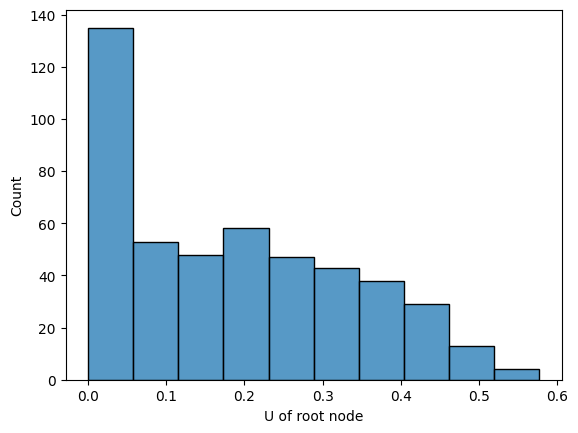

In [177]:
ax = sns.histplot(root_node_Us)
ax.set(xlabel='U of root node', ylabel='Count')


[Text(0.5, 0, 'U values'), Text(0, 0.5, 'Count')]

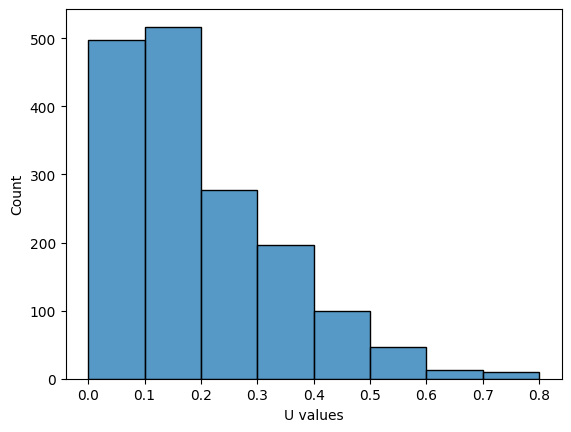

In [178]:
increment = 0.1
min_val = float(min(all_Us))-0.05
max_val = float(max(all_Us))+0.05
bins = [round(x * increment, 3) for x in range(int(min_val/increment), int(max_val/increment) + 1)]

ax = sns.histplot(all_Us, bins=bins)
ax.set(xlabel='U values', ylabel='Count')


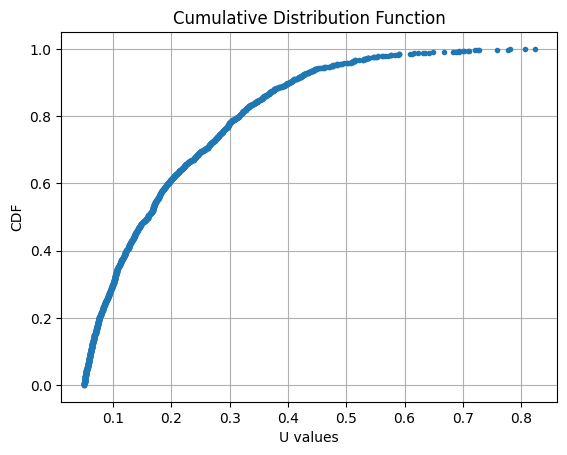

In [179]:
all_Us_sorted = np.sort(all_Us)

# Calculate the CDF values
cdf = np.arange(1, len(all_Us_sorted)+1) / len(all_Us_sorted)
plt.plot(all_Us_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('U values')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'U of parent - U of all descendants'), Text(0, 0.5, 'Count')]

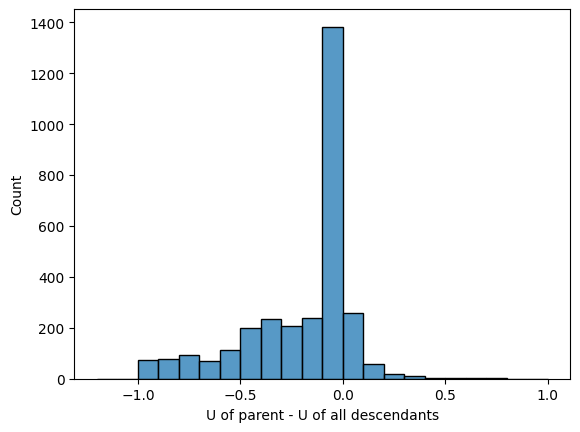

In [180]:
increment = 0.1
min_val = float(min(diff_of_node_and_descendants))-0.3
max_val = float(max(diff_of_node_and_descendants))+0.3
bins = [round(x * increment, 3) for x in range(int(min_val/increment), int(max_val/increment) + 1)]

ax = sns.histplot(diff_of_node_and_descendants, bins=bins)
ax.set(xlabel='U of parent - U of all descendants', ylabel='Count')


[Text(0.5, 0, '(U of node)/(U of node and all descendants)'),
 Text(0, 0.5, 'Count')]

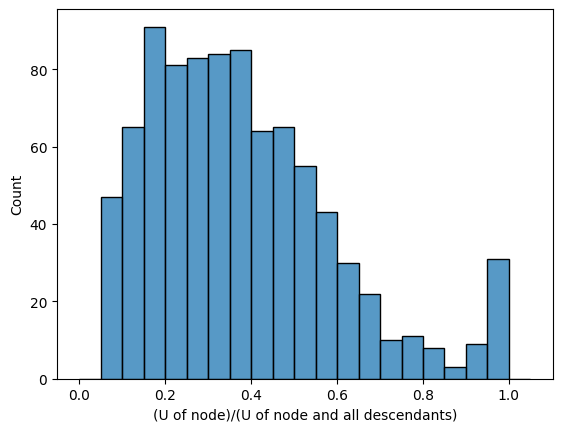

In [182]:
increment = 0.05
min_val = float(min(prop_of_node_and_descendants))-0.1
max_val = float(max(prop_of_node_and_descendants))+0.1
bins = [round(x * increment, 3) for x in range(int(min_val/increment), int(max_val/increment) + 1)]

ax = sns.histplot(prop_of_node_and_descendants, bins=bins)
ax.set(xlabel='(U of node)/(U of node and all descendants)', ylabel='Count')
